In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
import os 

os.chdir('E://bond-dex/bond-amm-research//')

In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
def lower_columns(df):
    df.columns = [c.lower() for c in df.columns]
    return df

In [5]:
T = 0.99
r_star = 0.05
x0 = 0.5 * np.exp(r_star*T)
y0 = 0.5 

kappa = 0.02 

r0 = kappa * np.log(x0/y0) + r_star

tau = T

In [6]:
def lob(tau, p, x0=x0, y0=y0, r_star=r_star):
    alpha = 1 / (1 + tau*kappa)
    K = np.exp(-tau * r_star * alpha)
    C = y0**alpha * (np.exp(1/kappa * (r0 - r_star)) + 1)
    q = C**(1/alpha) * (1/(1-alpha)) * K**(-1/(tau*kappa)) * (K + (p/K)**(1/(tau*kappa)))**(-2-tau*kappa) * p**(1/(tau*kappa) - 1)
    return q

In [7]:
def lob_yield(tau, p, x0=x0, y0=y0):
    C = x0**(1-tau) + y0**(1-tau)
    q = C**(1+tau) * (1+1/tau) * (1+p**(1/tau))**(-2-tau) * p**(1/tau-1)
    return q

In [18]:
p = np.arange(0.001, 3, 0.001)

In [24]:
lob_df = []

T = 10

for tau in [0.1, 1, 9]:
    q = lob(tau, p)
    q = np.sqrt(q)
    lob_df.append(pd.DataFrame({'tau': str(tau), 'p': p, 'q': q, 'func': 'polybond'}))
    
    q = lob_yield(tau/T, p)
    q = np.sqrt(q)
    lob_df.append(pd.DataFrame({'tau': str(tau), 'p': p, 'q': q, 'func': 'yield'}))
    
lob_df = pd.concat(lob_df)

In [30]:
import scienceplots
plt.style.use('ieee')

In [31]:
plt.rcParams["figure.figsize"] = (5,3)

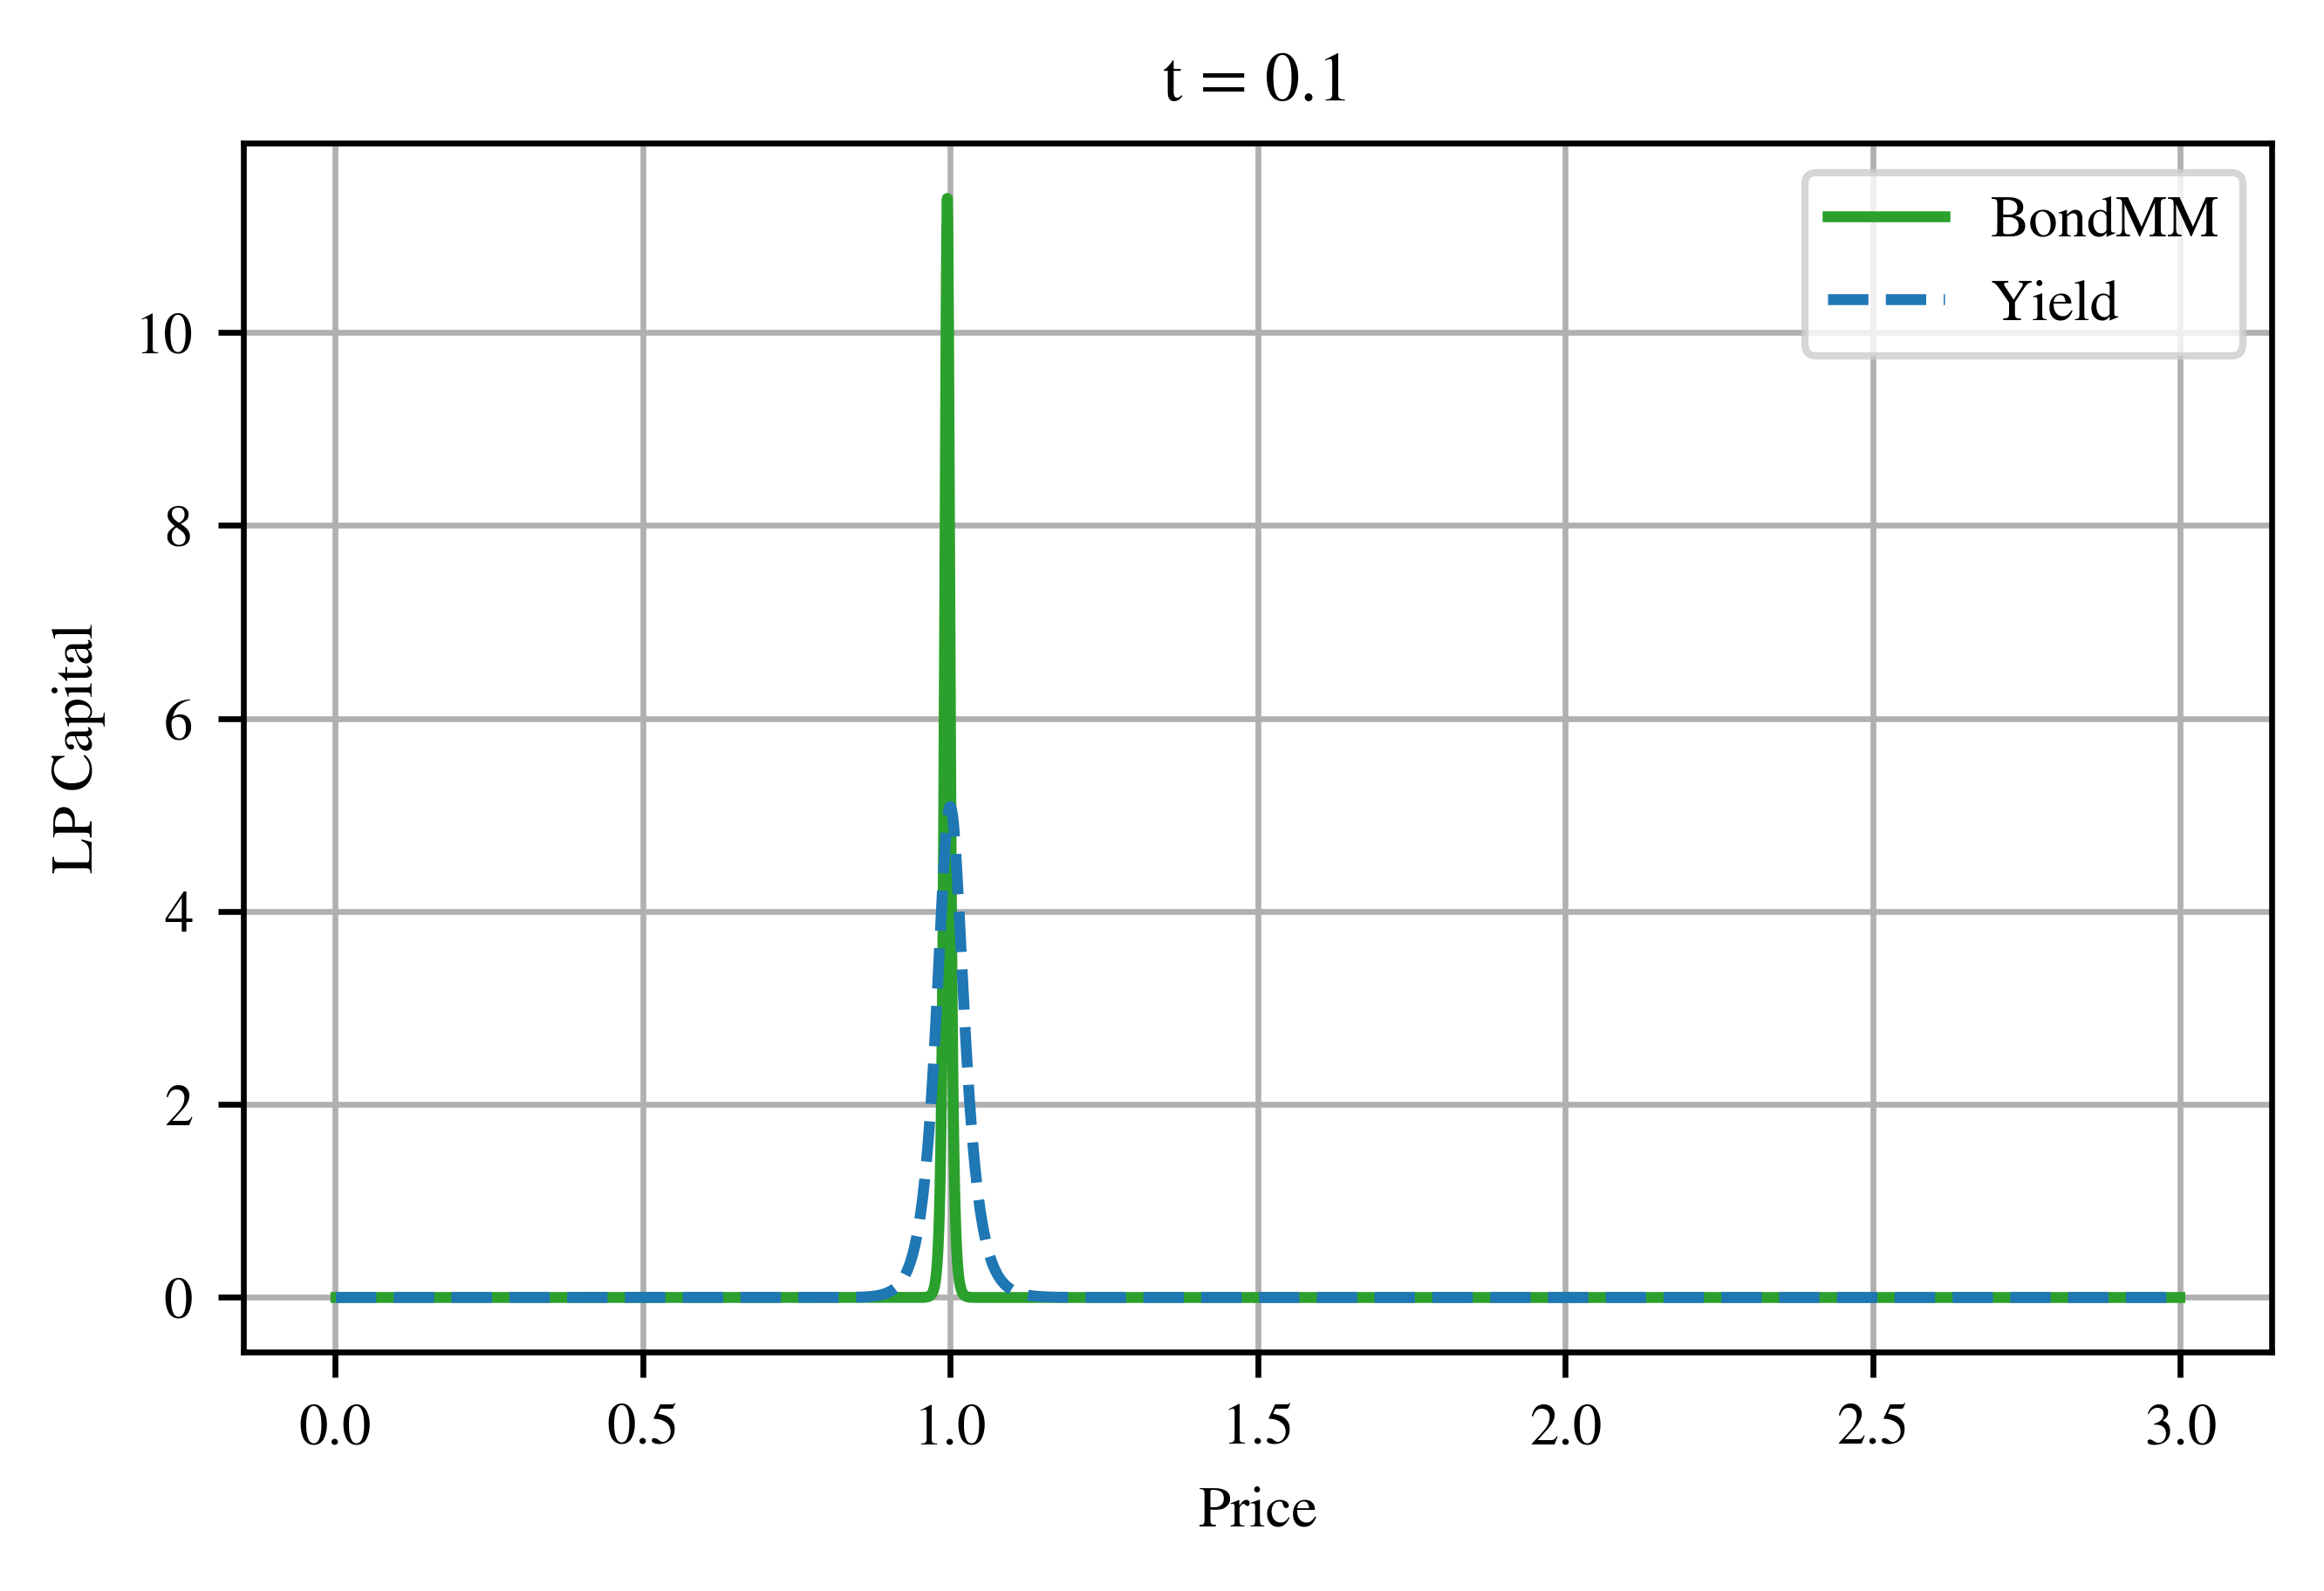

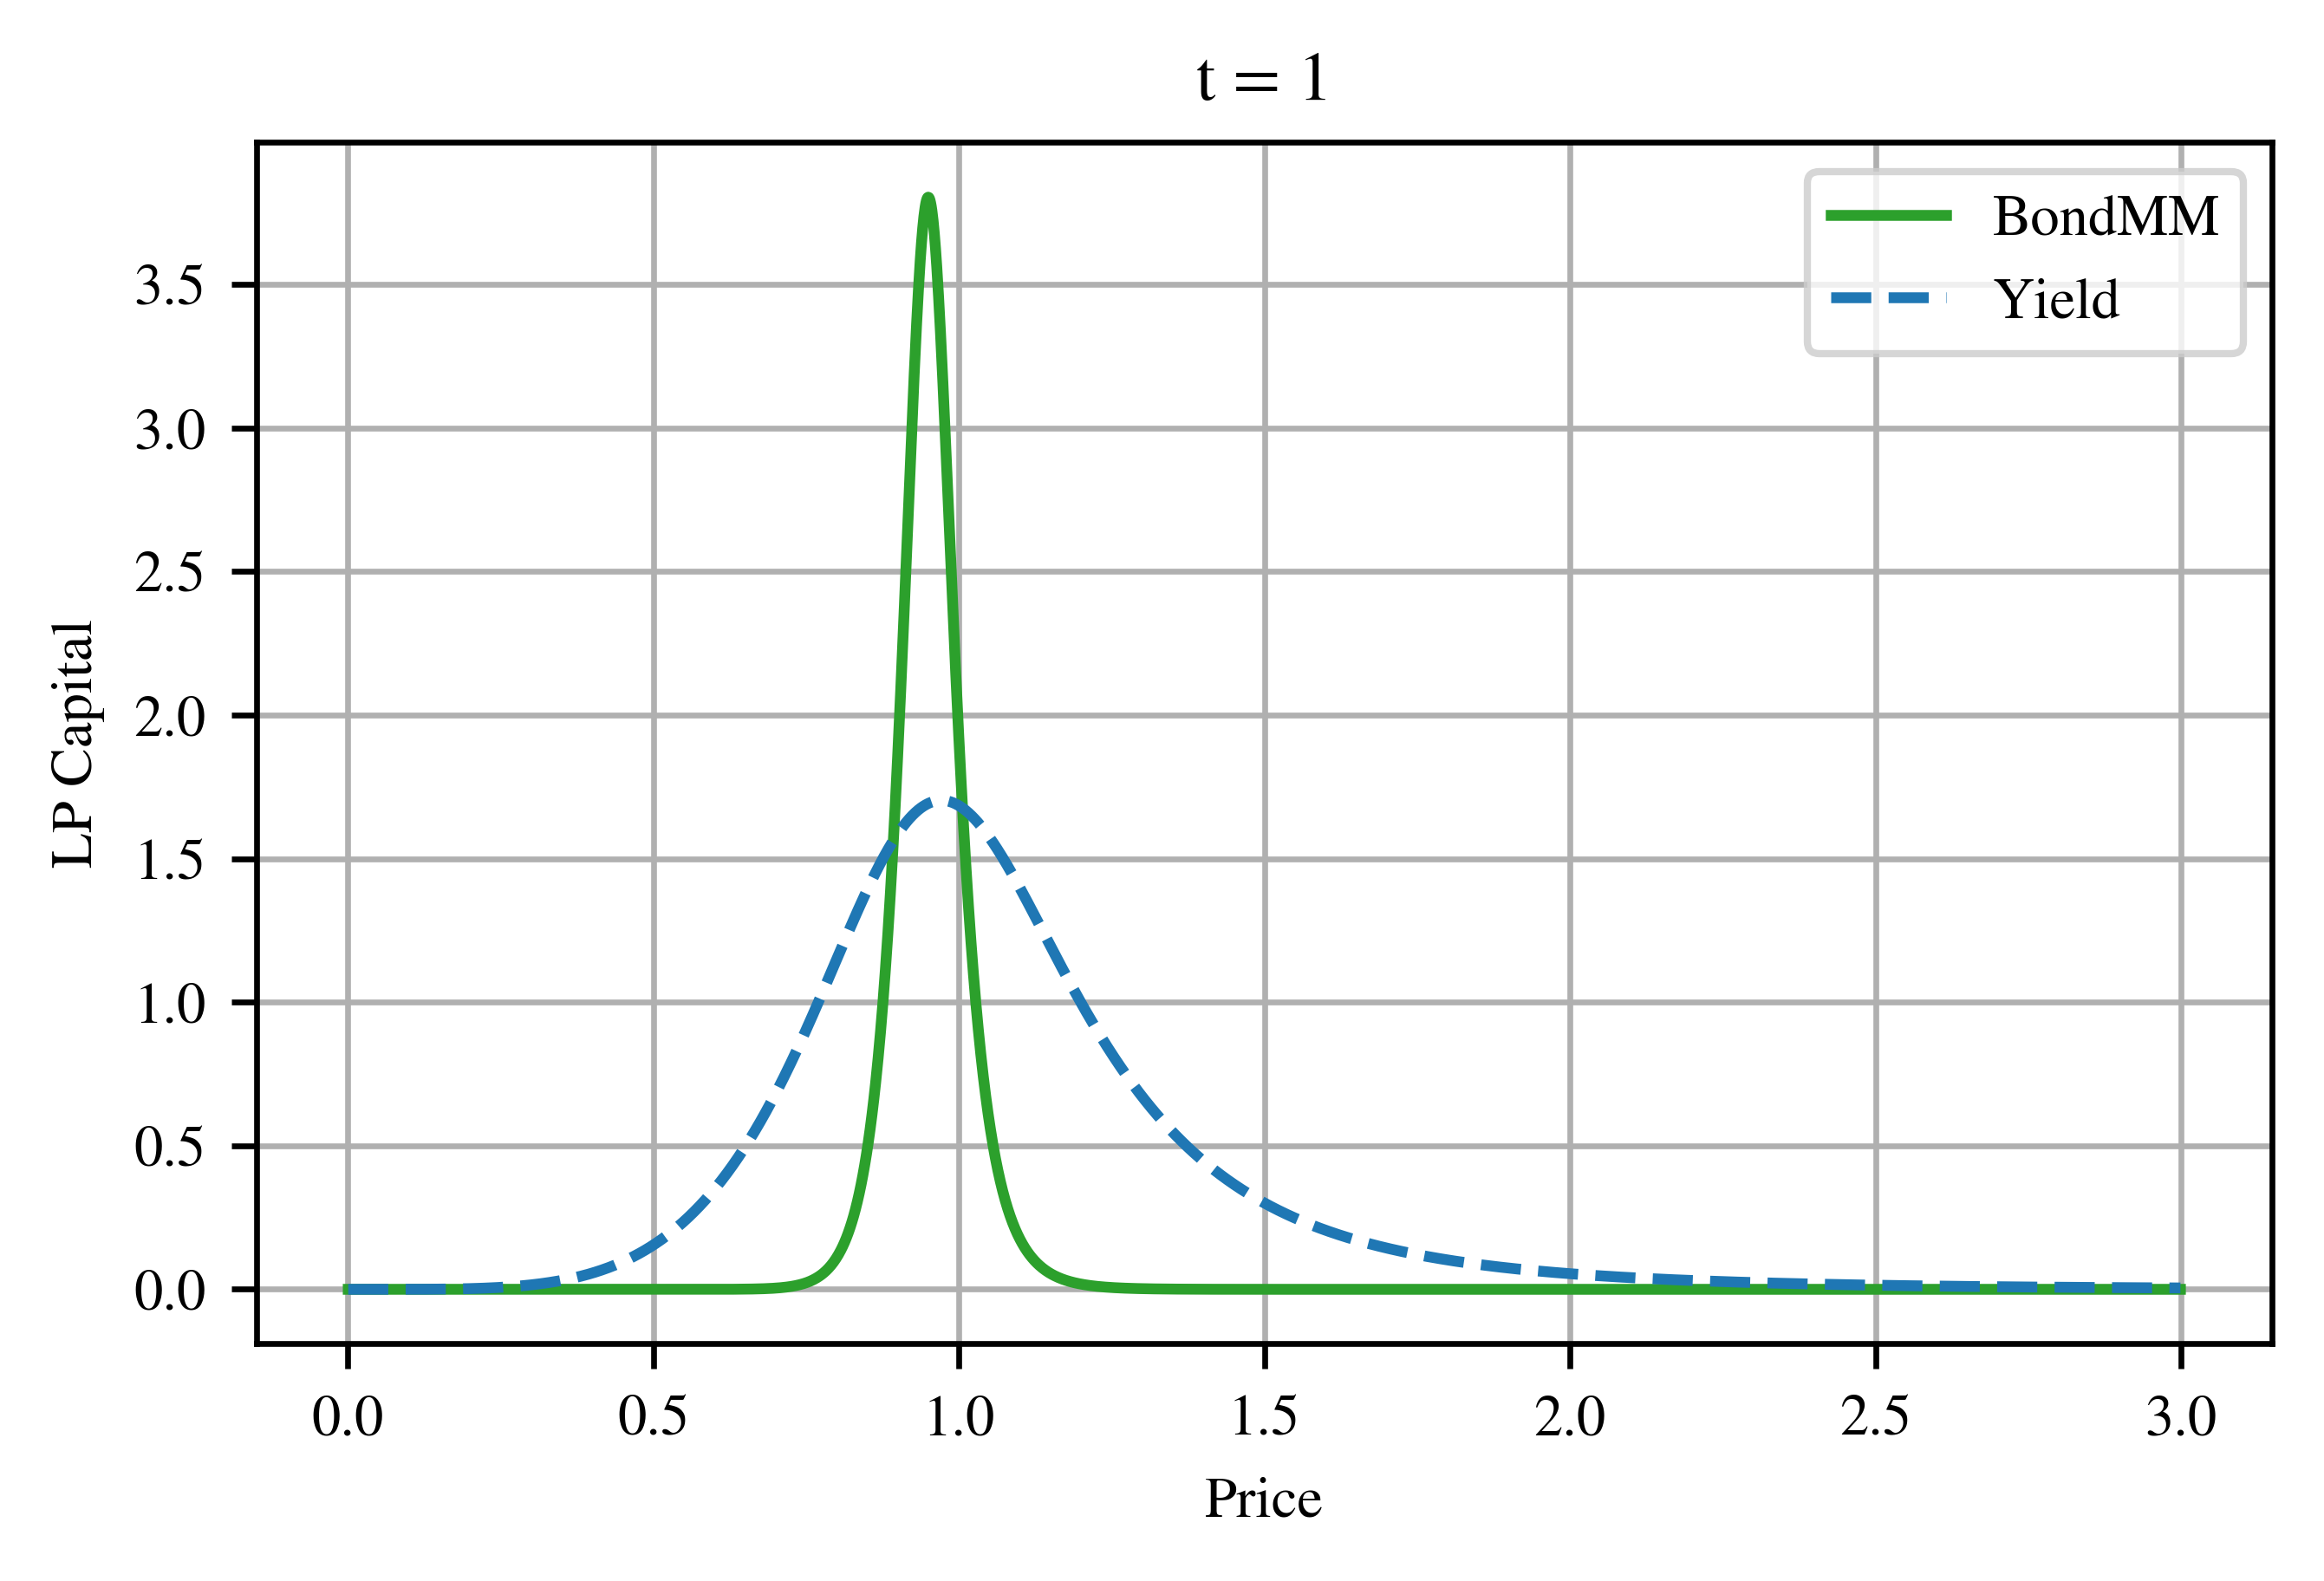

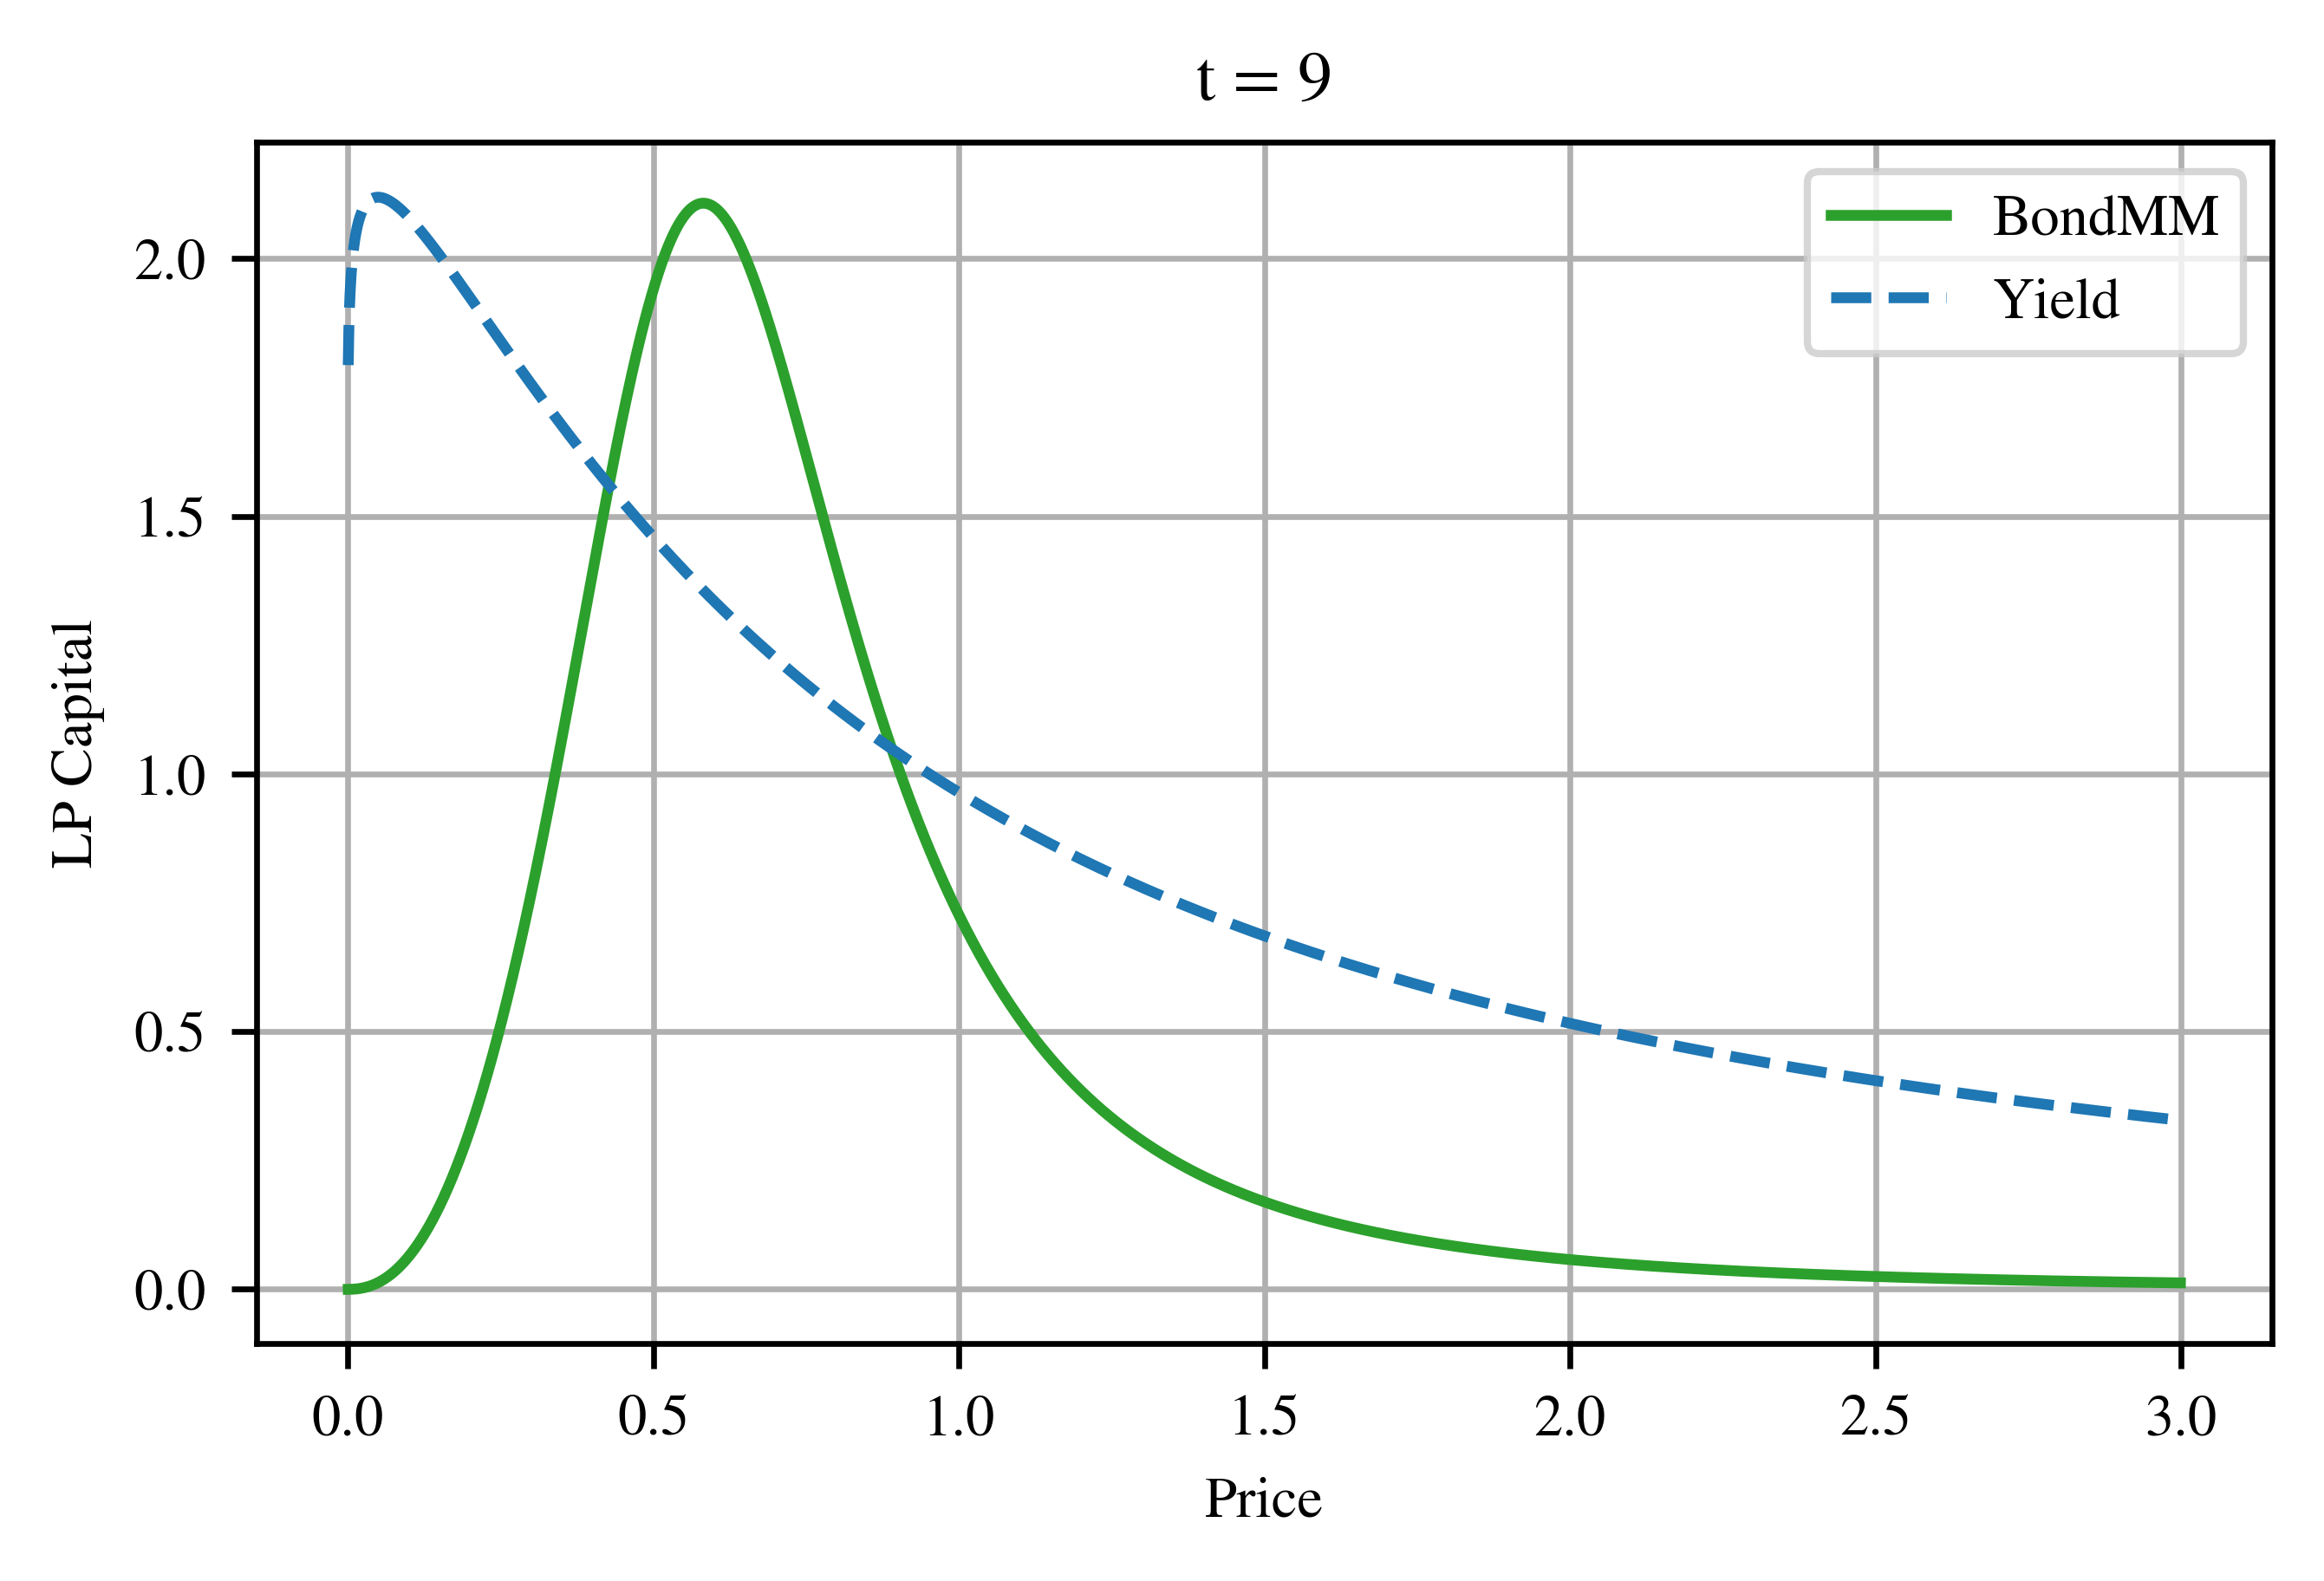

In [36]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 5), dpi=300)

# plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.13)

index = 0

for tau in lob_df.tau.unique(): 
    
    fig, axs = plt.subplots()
    
    plot_df = lob_df[lob_df.tau == tau]
    
    for func, color in zip(plot_df.func.unique(), ['tab:green', 'tab:blue']):

        xdf = plot_df[plot_df.func == func].sort_values(by='q', ascending=False)
        xdf = xdf.sort_values(by='p')

        axs.plot(xdf.p, xdf.q, color=color, label=func)
    
    axs.set_xlabel('Price')
    axs.set_ylabel('LP Capital')
    axs.set_title(f't = {tau}')
    axs.grid()
    
    axs.legend(['BondMM', 'Yield'])
    
#     if index != 0: 
#         axs.set_ylabel('')
#     if index == 2: 
#         axs[index].legend(title='price_function', loc=(1.1, 0.7)) 

    index += 1

    # fig.text(0.5, 0, f'x0={round(x0, 2)}, y0={y0}, kappa={kappa}, r*={r_star}')

    fig.savefig(f'images/PriceDensity{index}.png', dpi=400, transparent=True)

    plt.show()

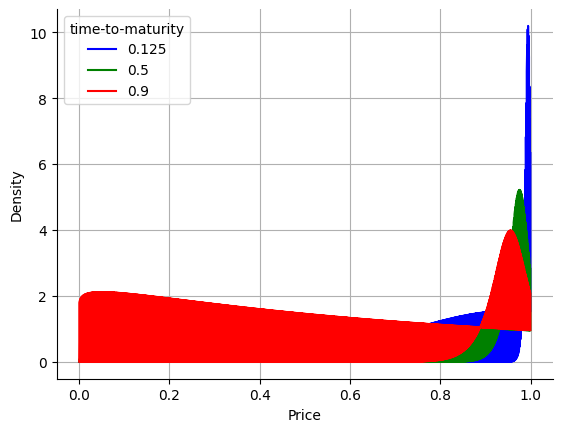

In [12]:
fig, ax = plt.subplots()

for tau, color in zip(lob_df.tau.unique(), ['blue', 'green', 'red']):

    xdf = lob_df[lob_df.tau == tau].sort_values(by='q', ascending=False)
    xdf = xdf.sort_values(by='p')

    ax.plot(xdf.p, xdf.q, color=color, label=tau)

ax.legend(title='time-to-maturity')    
    
ax.set_xlabel('Price')
ax.set_ylabel('Density')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid()

In [37]:
from scipy.special import logit

In [149]:
kappa = 0.02
dx = np.arange(-0.05, 0.05, 0.0011)

In [150]:
def yield_price(dx, x, y, tau):
    C = x**(1-tau) + y**(1-tau)
    x_new = x + dx
    y_new = (C - x_new**(1-tau))**(1/(1-tau))
    dy = y_new - y
    price = -dy/dx
    return price

In [151]:
def get_yield_impact(T=10):
    yield_impact = []

    for tau in [0.1, 1, 9]:
        price = yield_price(dx, x0, y0, tau=tau/T)
        p_dx = dx/x0
        price0 = yield_price(0.00001, x0, y0, tau=tau/T)
        p_price = abs(price / price0 - 1)

        yield_impact.append(pd.DataFrame({'tau': str(tau), 'd_volume': p_dx, 'd_price': p_price}))

    yield_impact = pd.concat(yield_impact)
    return yield_impact

In [152]:
def notional_price(dx, x, y, tau, kappa, r_star):
    p = (x + dx) / (x + y)
    price = 1 / (1 + tau * kappa * logit(p) + tau * r_star)
    return price

In [153]:
def get_notional_impact(kappa):

    notional_impact = []

    for tau in [0.1, 1, 9]: 
        price = notional_price(dx, x0, y0, tau=tau, kappa=kappa, r_star=r_star)
        p_dx = dx/x0
        price0 = notional_price(0, x0, y0, tau=tau, kappa=kappa, r_star=r_star)
        p_price = abs(price / price0 - 1)

        notional_impact.append(pd.DataFrame({'tau': str(tau), 'd_volume': p_dx, 'd_price': p_price}))

    notional_impact = pd.concat(notional_impact)
    return notional_impact

In [154]:
def polybond_price(dx, x, y, tau, kappa, r_star):
    alpha = 1 / (tau * kappa + 1)
    K = np.exp(-tau*r_star*alpha)
    
    price = (y - (K*x**alpha + y**alpha - K*(x+dx)**alpha)**(1/alpha))/dx
    return price

In [155]:
def get_polybond_impact(kappa):
    polybond_impact = []

    for tau in [0.1, 1, 9]:
        price = polybond_price(dx, x0, y0, tau=tau, kappa=kappa, r_star=r_star)
        p_dx = dx/x0
        price0 = polybond_price(0.00001, x0, y0, tau=tau, kappa=kappa, r_star=r_star)
        p_price = abs(price / price0 - 1)

        polybond_impact.append(pd.DataFrame({'tau': str(tau), 'd_volume': p_dx, 'd_price': p_price}))

    polybond_impact = pd.concat(polybond_impact)
    return polybond_impact

In [156]:
import matplotlib as mpl
from matplotlib.transforms import Bbox

def full_extent(ax, xpad=0.0, ypad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1 + xpad, 1 + ypad)

In [157]:
kappa = 0.02 
notional_impact = get_notional_impact(kappa)
polybond_impact = get_polybond_impact(kappa)

In [158]:
polybond_impact

,tau,d_volume,d_price
0,0.1,-0.095171,0.000194
1,0.1,-0.093077,0.000190
2,0.1,-0.090983,0.000186
3,0.1,-0.088889,0.000182
4,0.1,-0.086796,0.000177
...,...,...,...
86,9,0.084892,0.010889
87,9,0.086986,0.011153
88,9,0.089080,0.011417
89,9,0.091173,0.011680


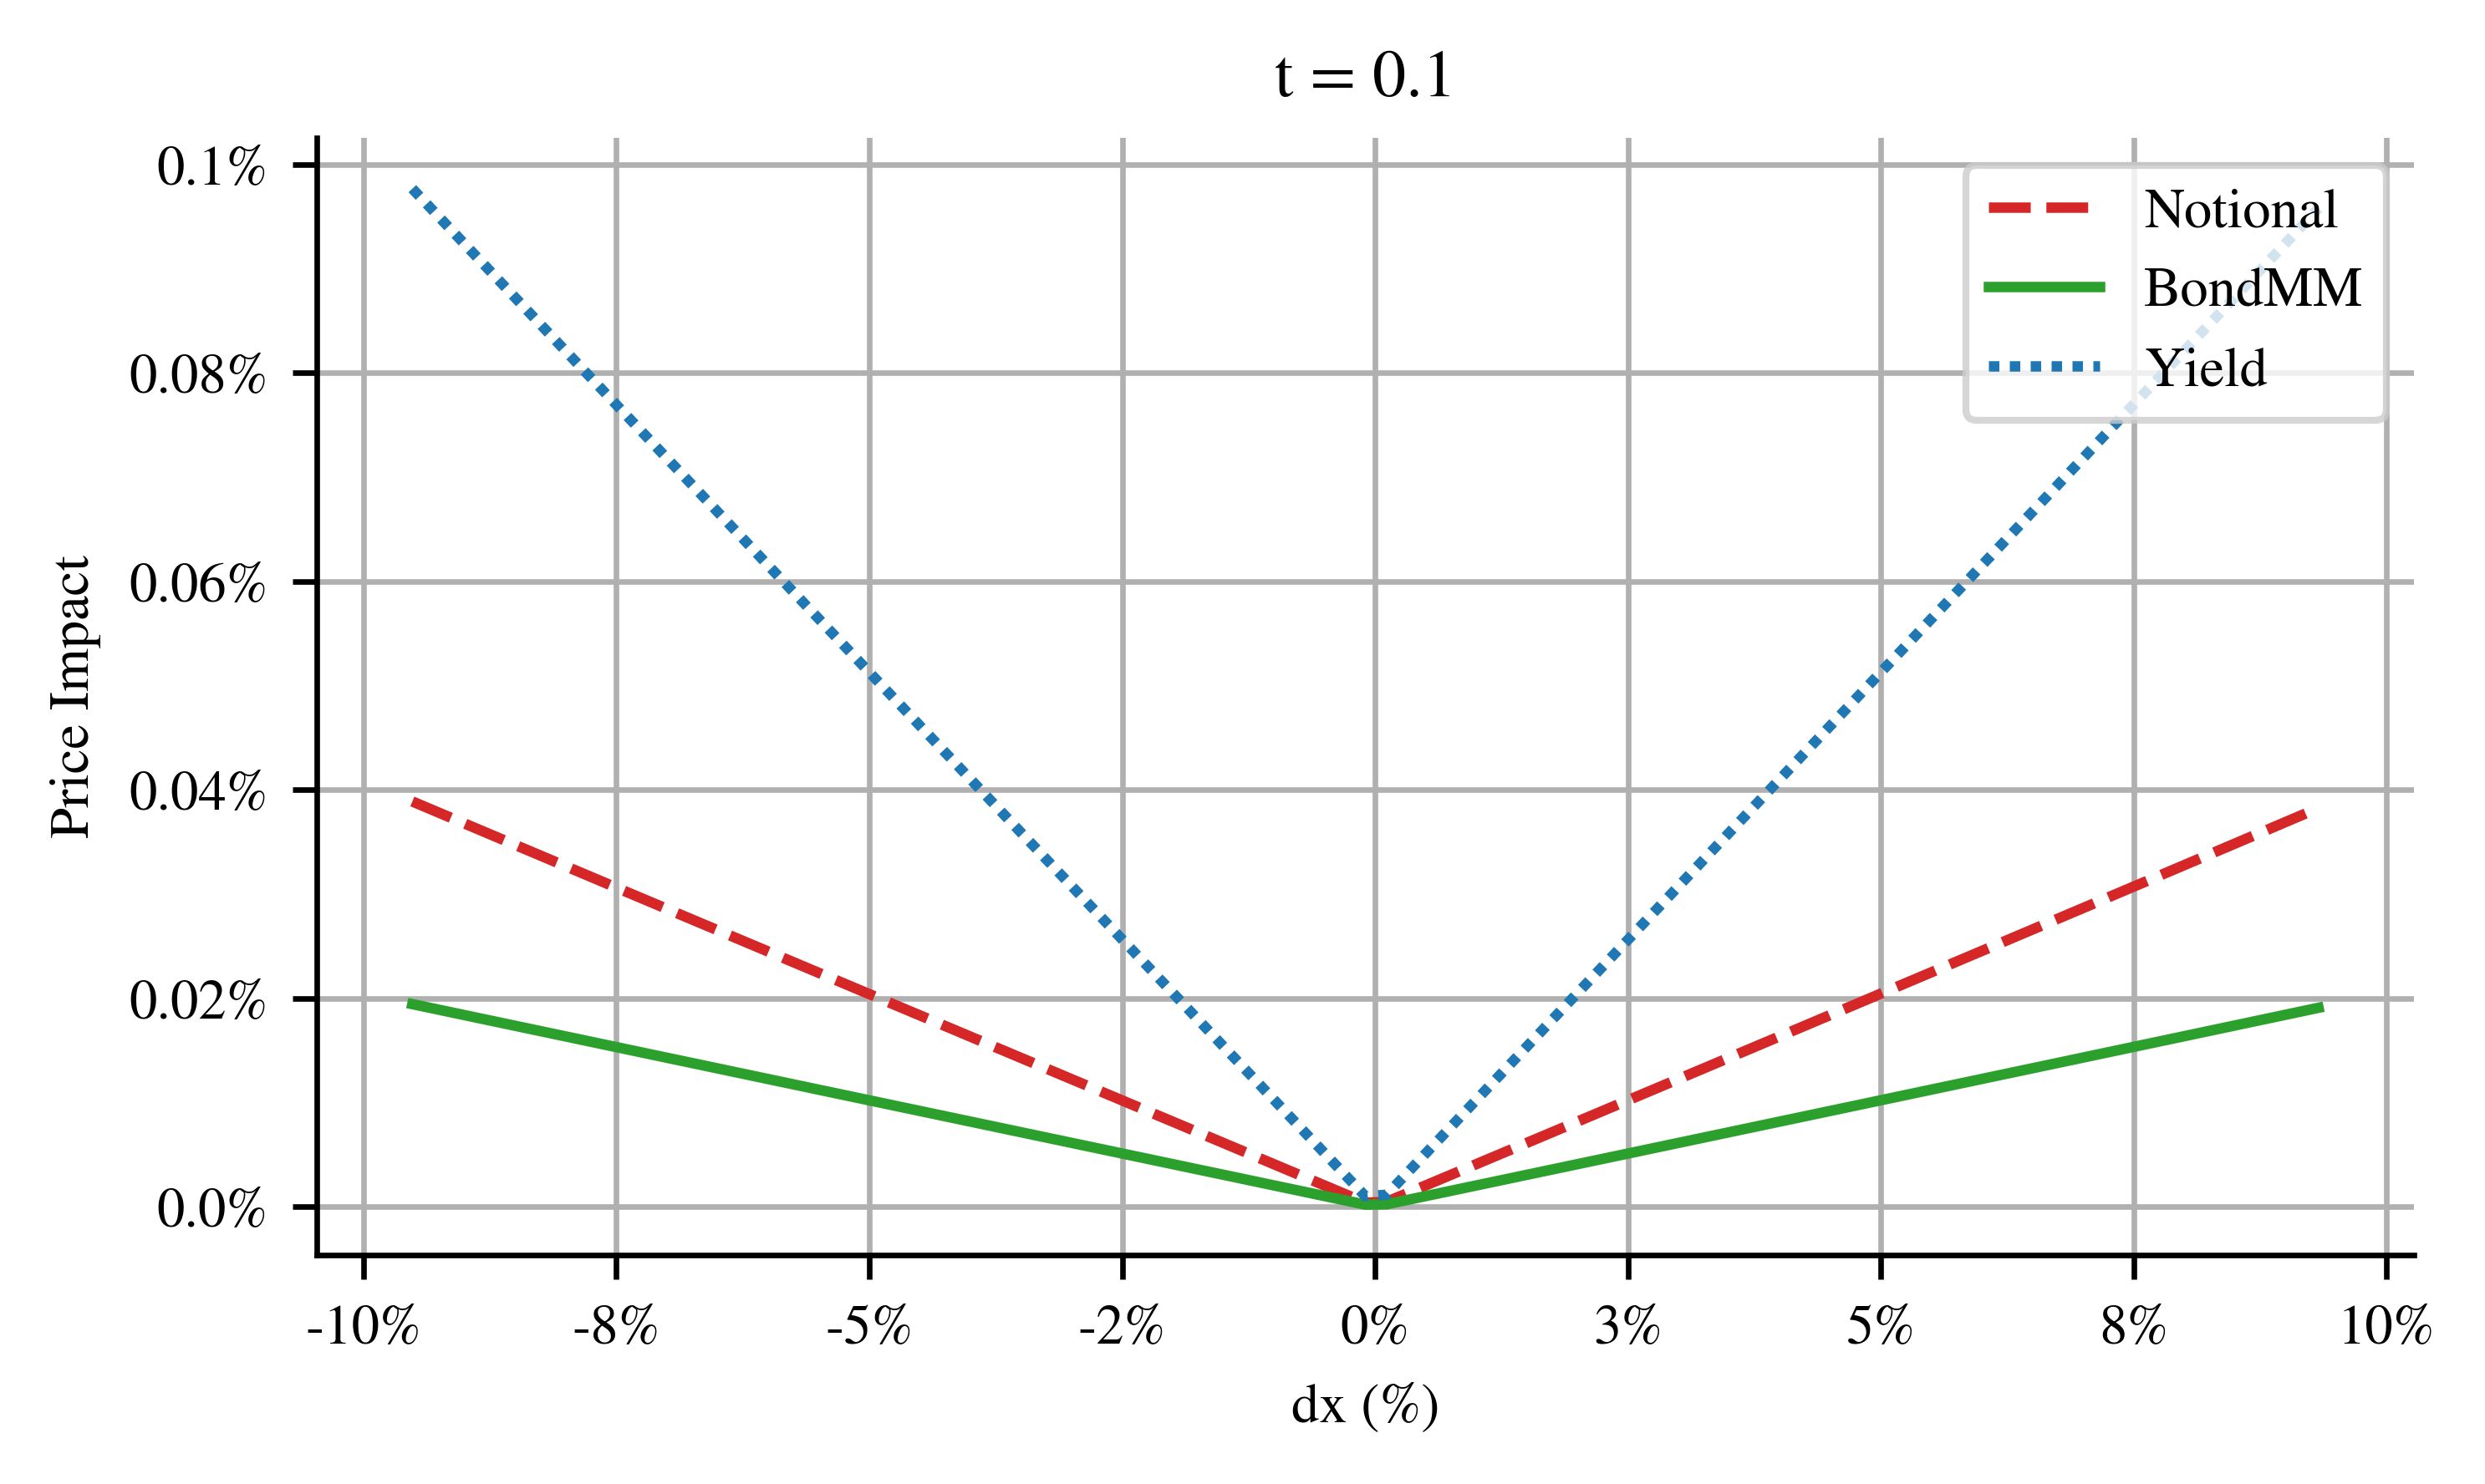

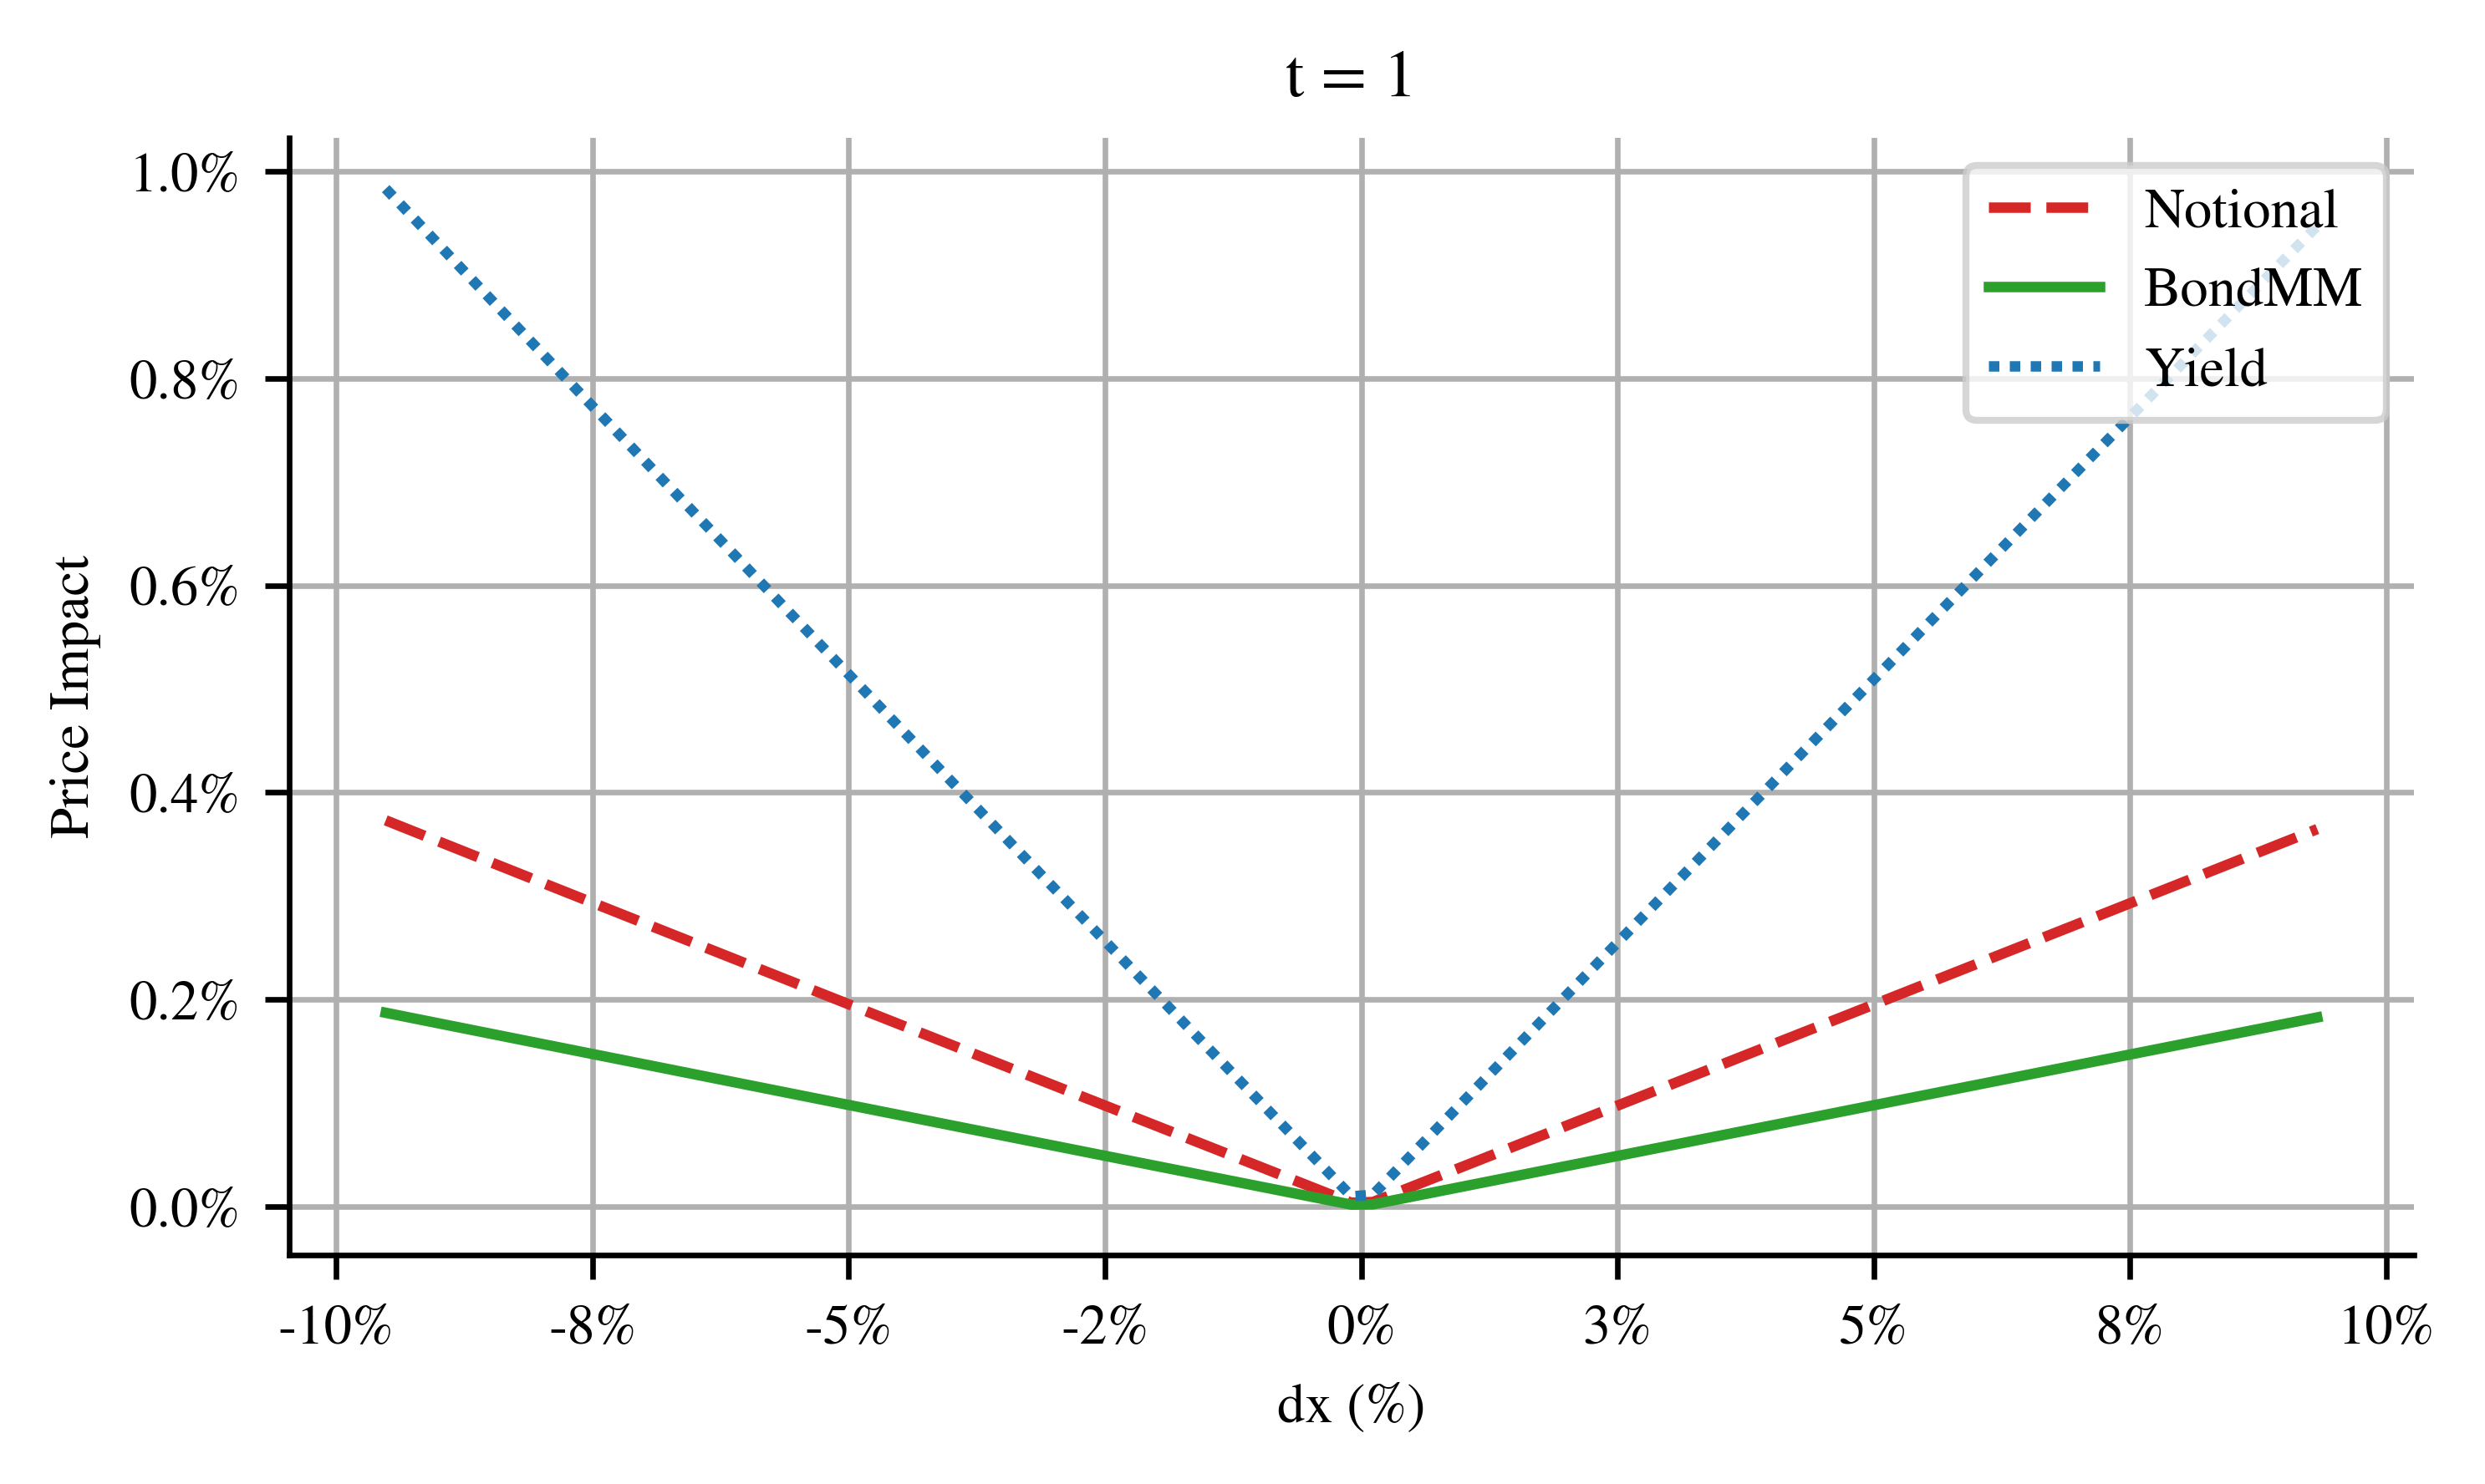

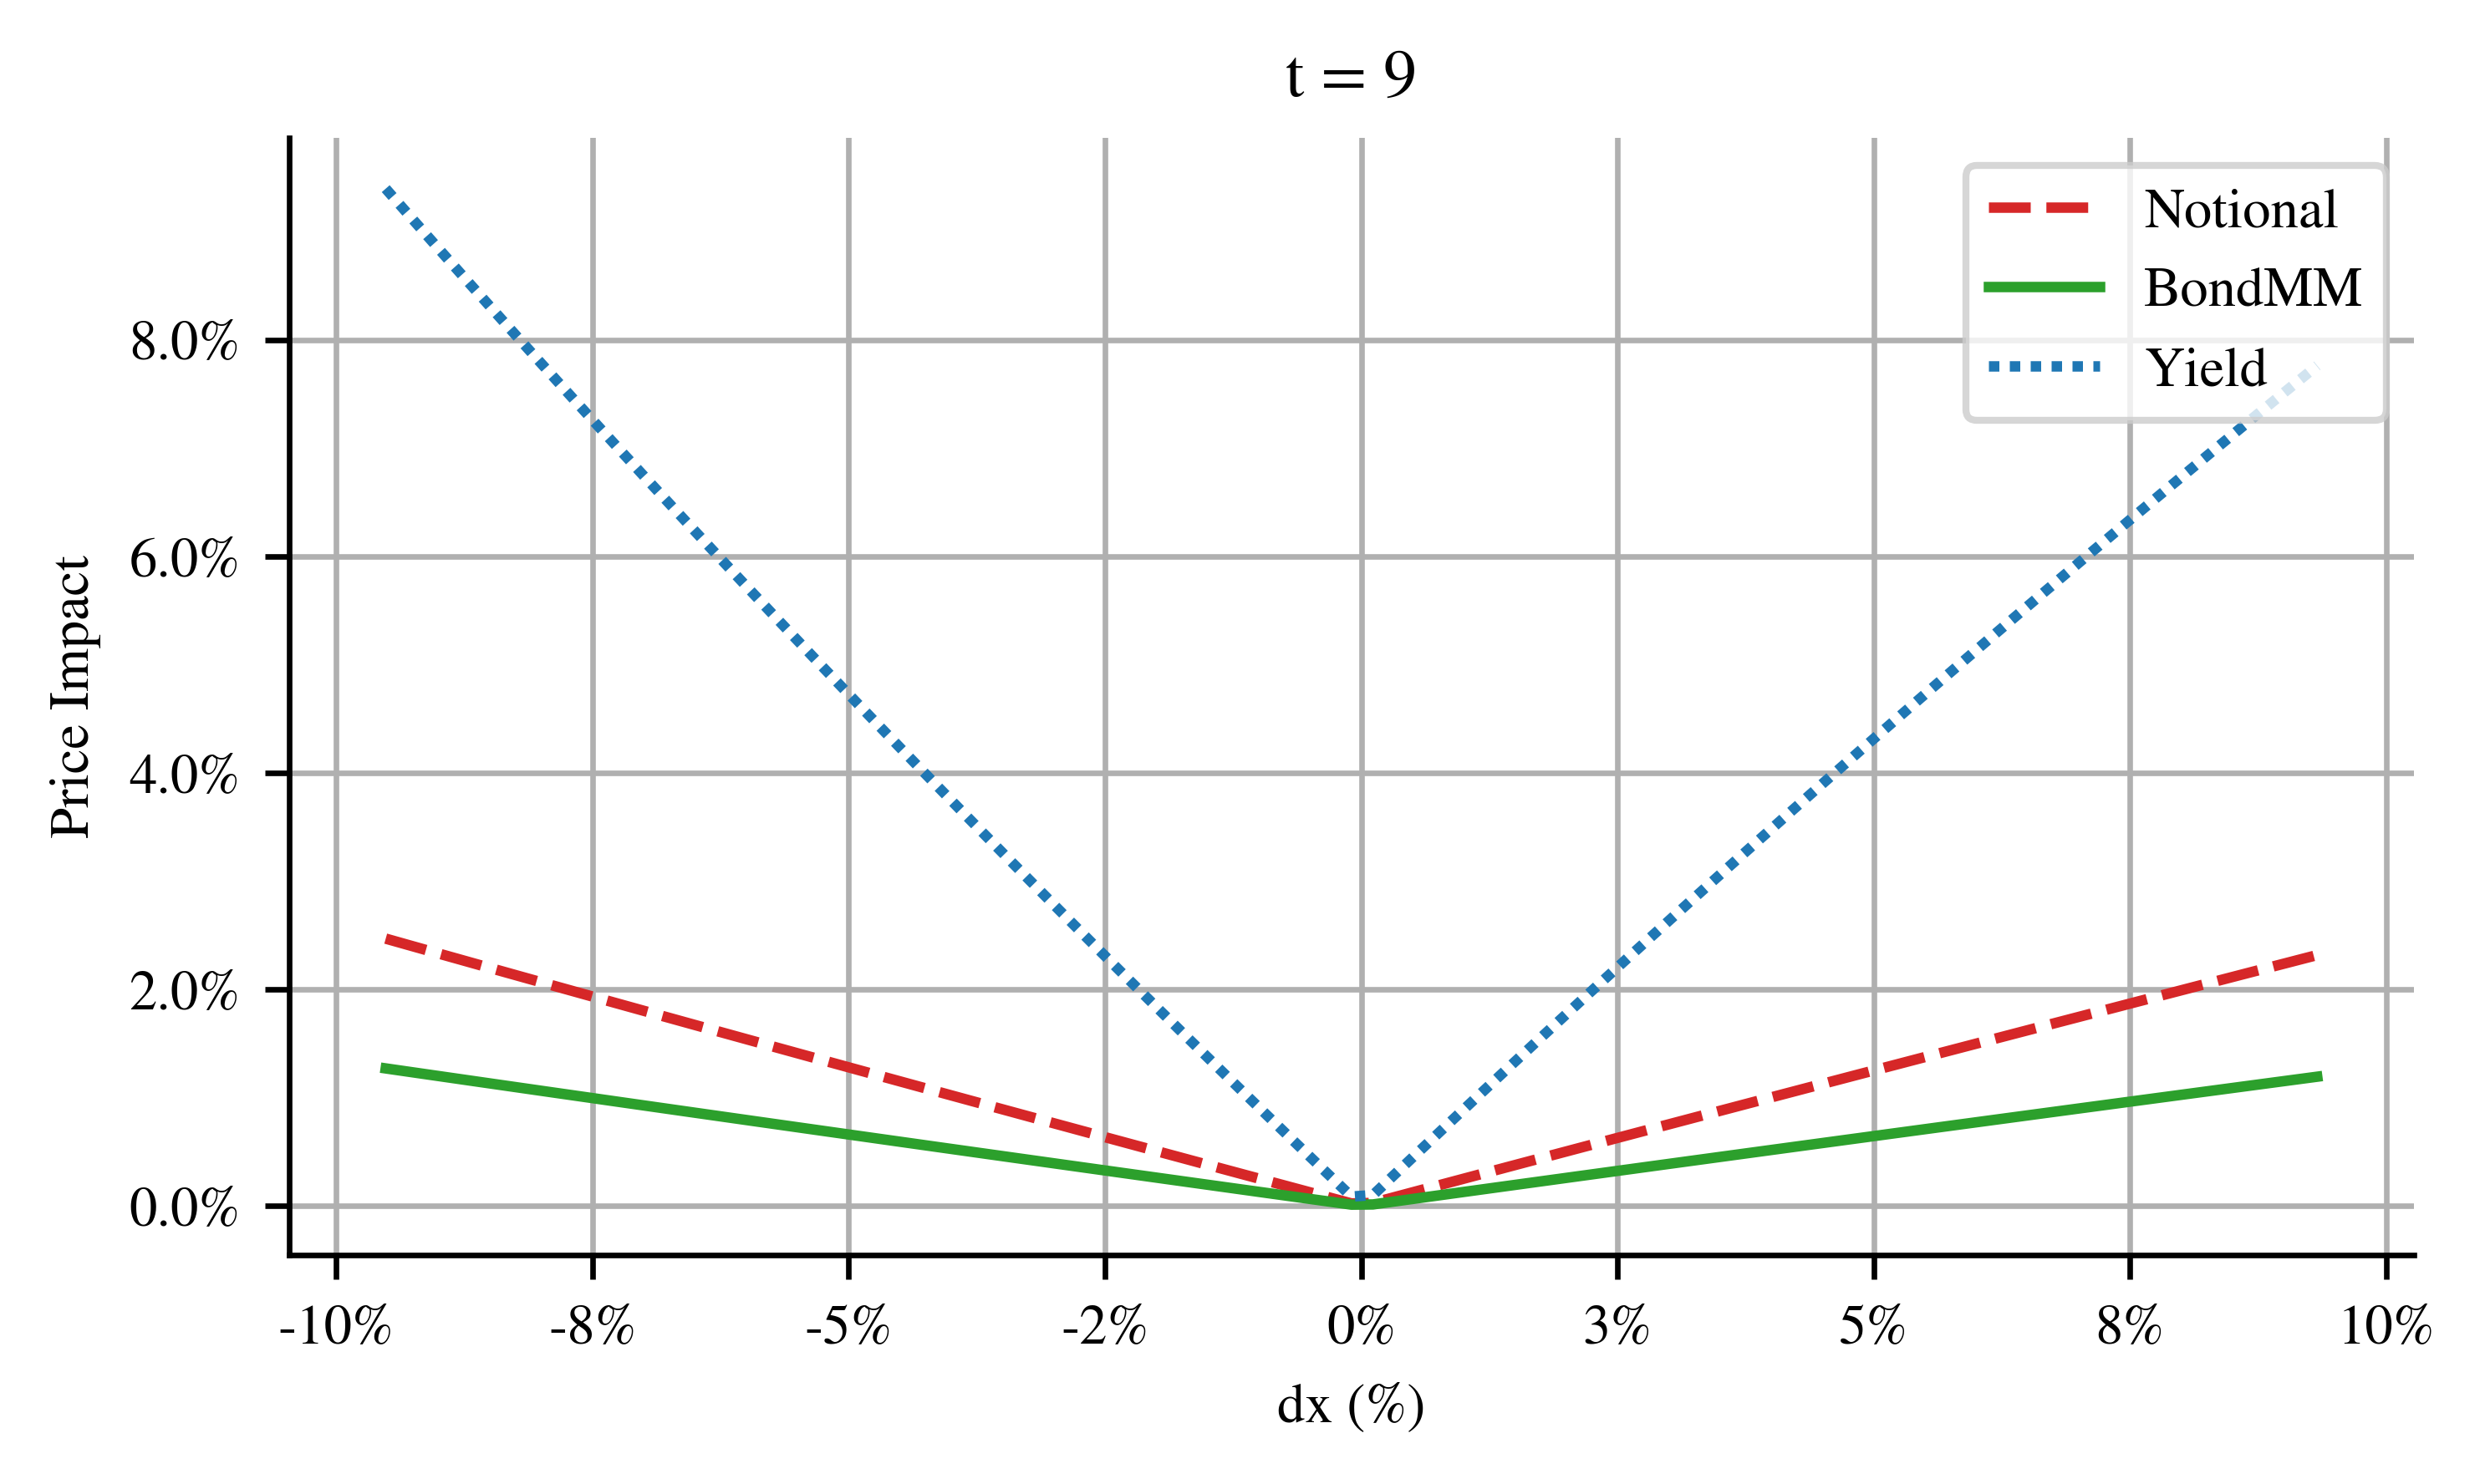

In [159]:
for kappa in [0.02]: 
    
    notional_impact = get_notional_impact(kappa)
    notional_impact['protocol'] = 'Notional'
    polybond_impact = get_polybond_impact(kappa)
    polybond_impact['protocol'] = 'BondMM'
    yield_impact = get_yield_impact()
    yield_impact['protocol'] = 'Yield'
    
    impact = pd.concat([notional_impact, polybond_impact, yield_impact])
    
    ymin = notional_impact.d_price.min()
    ymax = notional_impact.d_price.max() * 1.05
    
    index = 0
    
    for tau in [0.1, 1, 9]: 
        
        index += 1
        
        fig, ax = plt.subplots()
        
        plt_df = impact[impact.tau.astype('float') == tau]
#         plt1_df = polybond_impact[polybond_impact.tau.astype('float') == tau]
#         plt2_df = notional_impact[notional_impact.tau.astype('float') == tau]
        sns.lineplot(data=plt_df, x='d_volume', y='d_price', hue='protocol', ax=ax, 
                     palette={'BondMM': 'tab:green', 'Notional': 'tab:red', 'Yield': 'tab:blue'}, 
                     style='protocol', style_order=['BondMM', 'Notional', 'Yield'] 
                    )
#         ax.plot(plt1_df.d_volume, plt1_df.d_price, label='BondMM', color='tab:green')
#         ax.plot(plt2_df.d_volume, plt1_df.d_price, label='BondMM', color='tab:red')

#         ax.set_ylim(ymin, ymax)

        xtks = ax.get_xticks()
        ytks = ax.get_yticks()

        ax.set_xticklabels([f'{int(round(tk*100))}%' for tk in xtks])
        ax.set_yticklabels([f'{round(tk*100, 2)}%' for tk in ytks])

        ax.set_title(f't = {tau}', x=0.5, y=1)
#         ax.text(0, 0, f' kappa: {kappa}')

        ax.legend(loc='upper right')

        ax.set_xlabel('dx (%)')
        ax.set_ylabel('Price Impact')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.grid()
        
        fig.tight_layout()
        
        fig.savefig(f'images/PriceImpact{index}.png', dpi=400, transparent=True)
    
# fig.suptitle(f'kappa={kappa}, x0={round(x0, 2)}, y0={round(y0, 2)}, r0={round(r0*100, 2)}%', 
#              x=0.1, y=1.01, horizontalalignment='left')

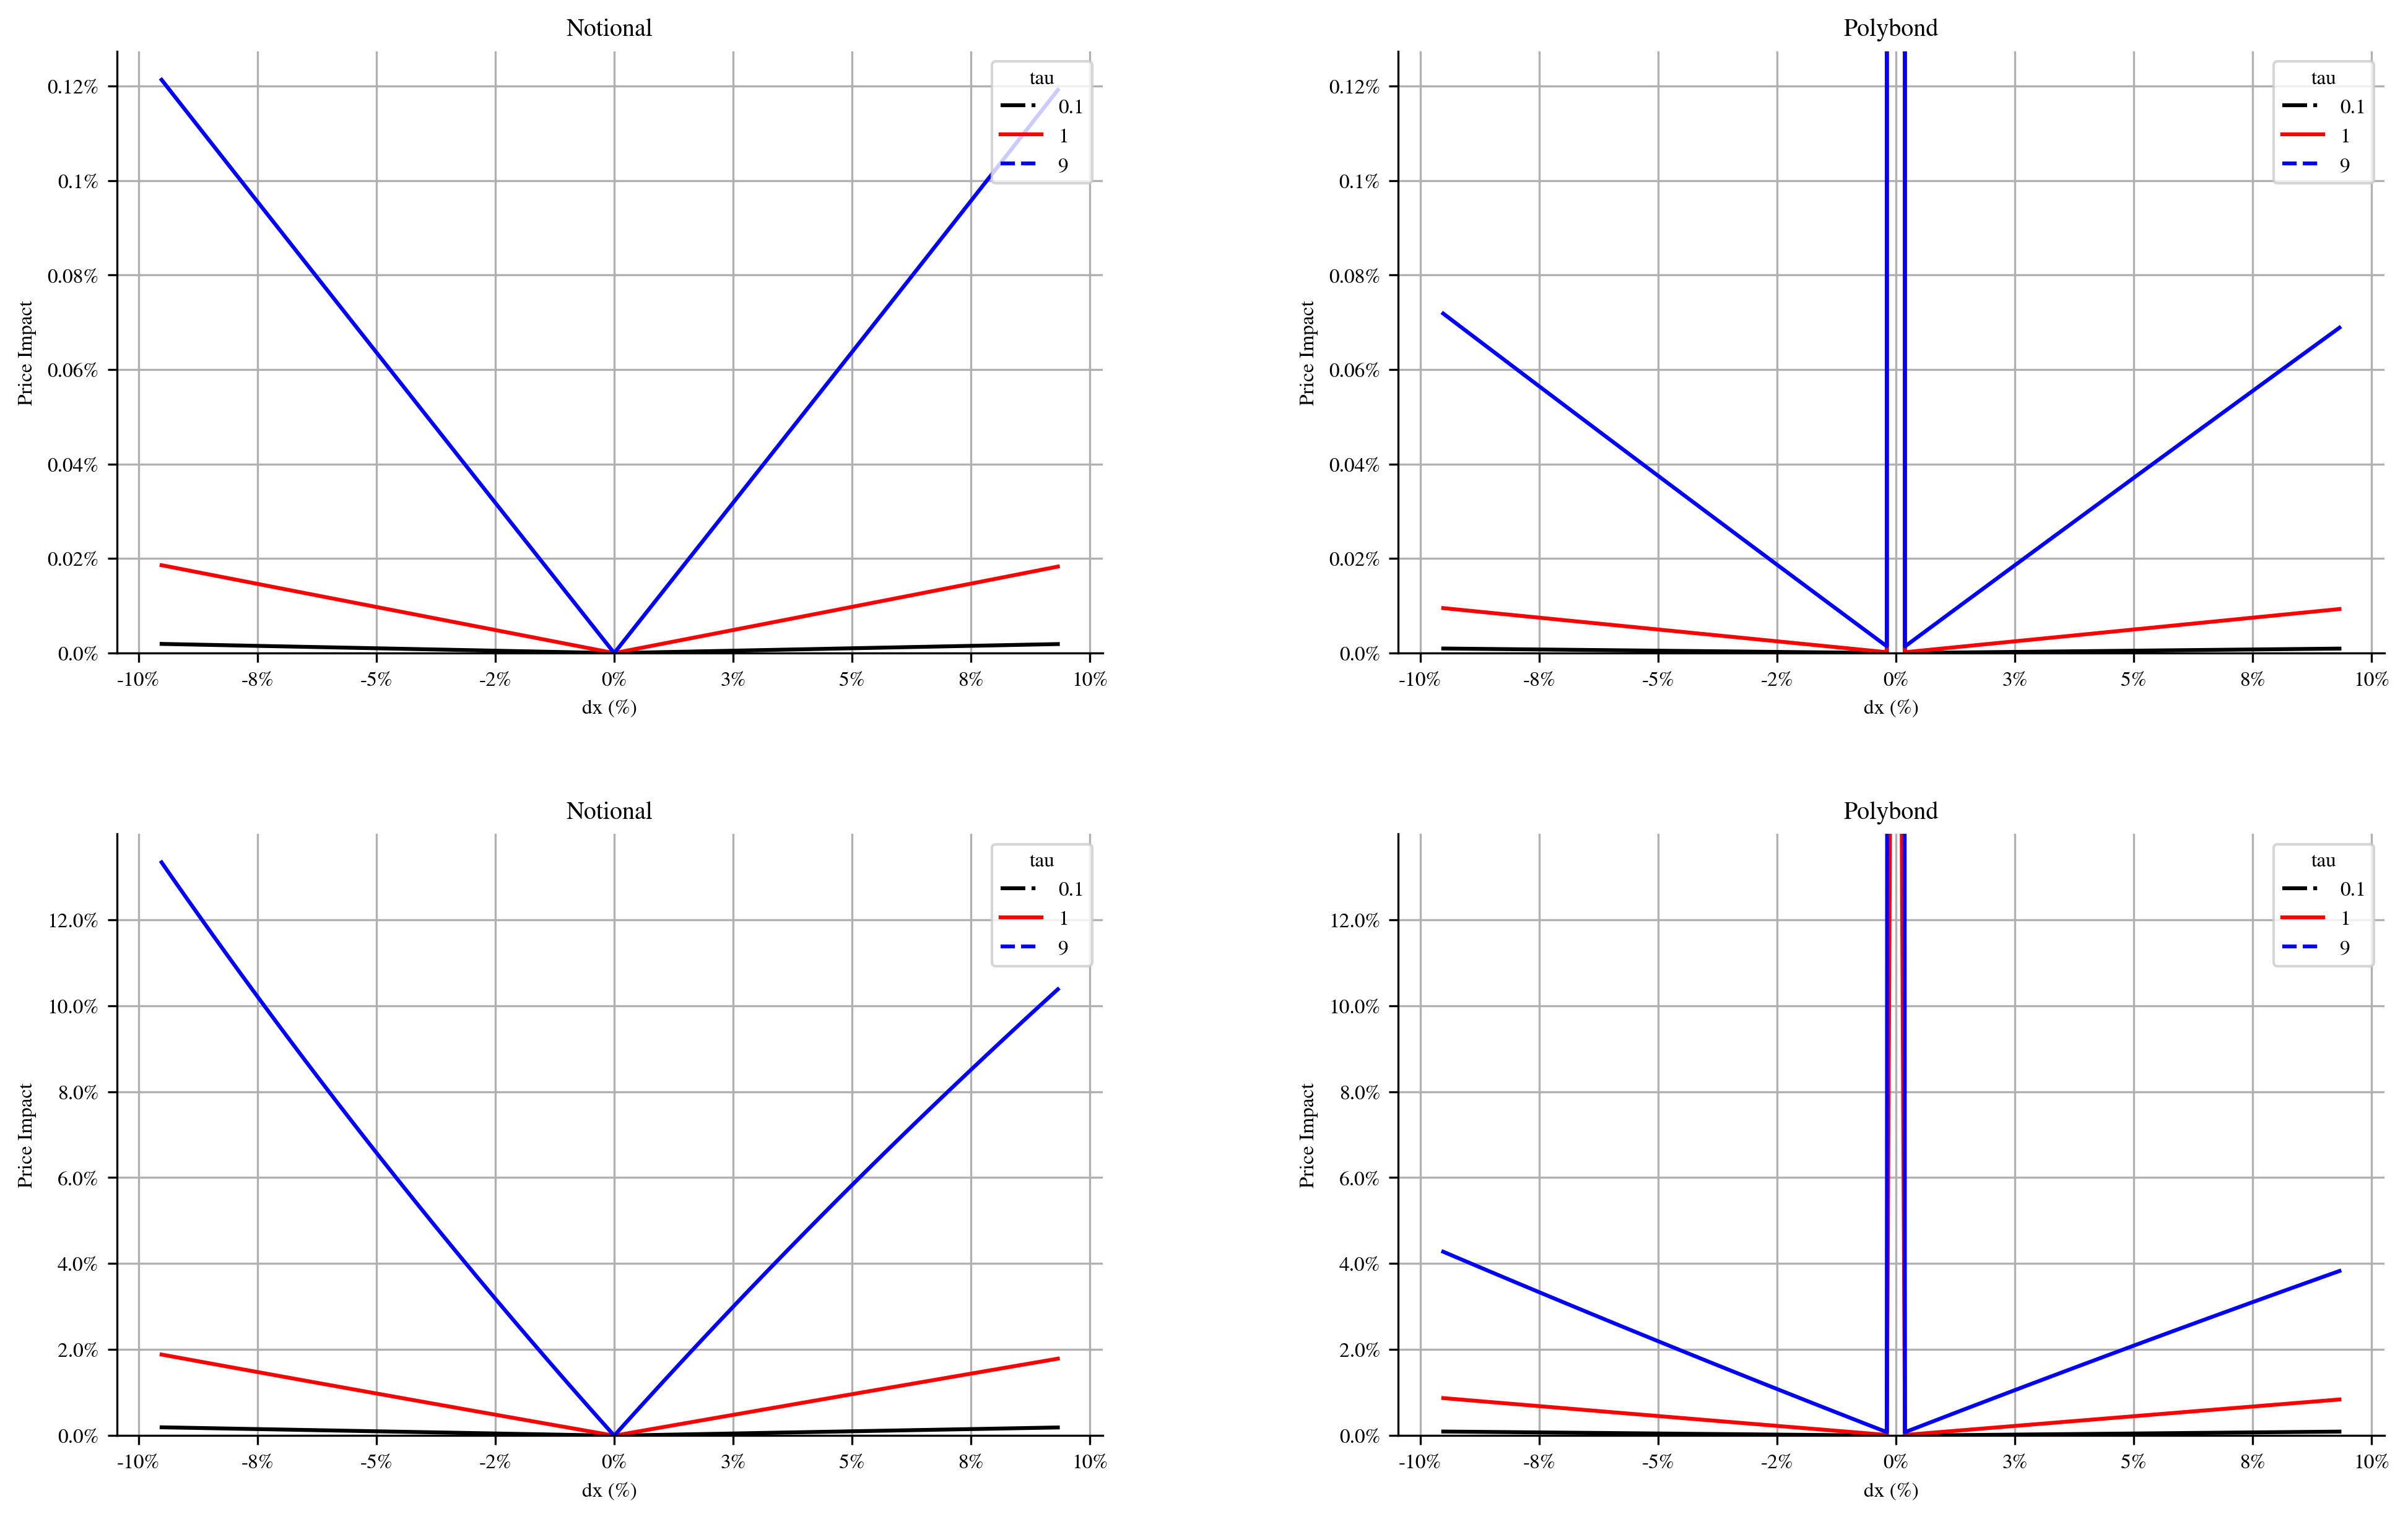

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(13, 8), dpi=300)

fig.subplots_adjust(
    top=0.981,
    bottom=0.049,
    left=0.042,
    right=0.981,
    hspace=0.3,
    wspace=0.3
)

for ind1, kappa in zip([0, 1], [0.001, 0.1]): 
    
    notional_impact = get_notional_impact(kappa)
    polybond_impact = get_polybond_impact(kappa)
    
    ymin = notional_impact.d_price.min()
    ymax = notional_impact.d_price.max() * 1.05
    
    for id2, impact, label in zip([0, 1], [notional_impact, polybond_impact], ['Notional', 'Polybond']): 
        ax = axs[ind1, id2]
        sns.lineplot(data=impact, x='d_volume', y='d_price', hue='tau', ax=ax)

        ax.set_ylim(ymin, ymax)

        xtks = ax.get_xticks()
        ytks = ax.get_yticks()

        ax.set_xticklabels([f'{int(round(tk*100))}%' for tk in xtks])
        ax.set_yticklabels([f'{round(tk*100, 2)}%' for tk in ytks])

        ax.set_title(label, x=0.5, y=1)
#         ax.text(0, 0, f' kappa: {kappa}')

        ax.legend(title='tau', loc='upper right')

        ax.set_xlabel('dx (%)')
        ax.set_ylabel('Price Impact')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.grid()
    
# fig.suptitle(f'kappa={kappa}, x0={round(x0, 2)}, y0={round(y0, 2)}, r0={round(r0*100, 2)}%', 
#              x=0.1, y=1.01, horizontalalignment='left')

In [136]:
extent = full_extent(axs[1, 0], xpad=0.05, ypad=0.15).transformed(fig.dpi_scale_trans.inverted())

fig.savefig('images/Notional_PriceImpact_kappa=0.1.png', bbox_inches=extent, transparent=True)

## Fee

In [100]:
def fee1(tau, gamma, kappa):
    return kappa * np.log(1 + gamma*tau)

In [107]:
tau = np.arange(0.01, 50, 0.01)

In [108]:
gamma = 0.00125/0.05

In [109]:
df = []

for kappa in [0.001, 0.1]: 
    fee = fee1(tau, gamma, kappa)
    df.append(
        pd.DataFrame({'tau': tau, 'kappa': str(kappa), 'fee': fee})
    )
    
df = pd.concat(df)

<Axes: xlabel='tau', ylabel='fee'>

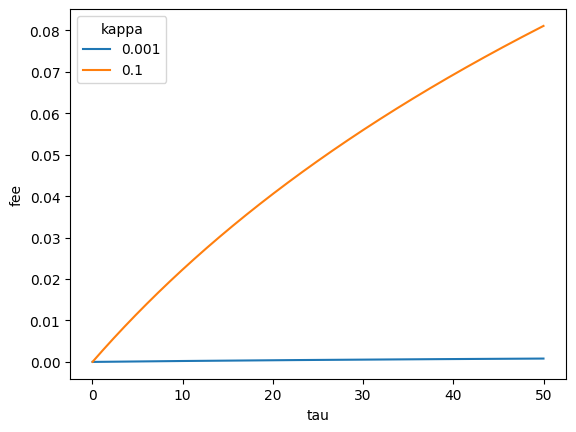

In [110]:
sns.lineplot(data=df, x='tau', y='fee', hue='kappa')